# space-filling curve

## utils

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
import torch as t

In [2]:
def plot(points, ax=None, figsize=(4, 4)):
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    x, y = zip(*points)
    ax.plot(x, y)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.tick_top()
    ax.invert_yaxis()
    plt.tight_layout()

def plot_gradient(points, ax=None, figsize=(4, 4), cmap='viridis', smidge_coef=0.05):
    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.gca()
    points = t.tensor(points)
    segments = t.cat([points[:-1, None], points[1:, None]], dim=1)
    norm = plt.Normalize(0, len(segments))
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t.arange(len(segments)))
    ax.add_collection(lc)
    x, y = points[:, 0], points[:, 1]
    smidge = abs(x.max() - x.min()) * smidge_coef
    ax.set_xlim(x.min() - smidge, x.max() + smidge)
    ax.set_ylim(y.min() - smidge, y.max() + smidge)    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.tick_top()
    ax.invert_yaxis()
    plt.tight_layout()

def plot_orders(f, orders=[1, 2, 3, 4, 5, 6]):
    n = len(orders)
    fig, axs = plt.subplots(2, n, figsize=(4 * n, 4 * 2))
    for i, size in enumerate(orders):
        points = f(size)
        plot(points, ax=axs[0, i])
        plot_gradient(points, ax=axs[1, i])

## z-order curve

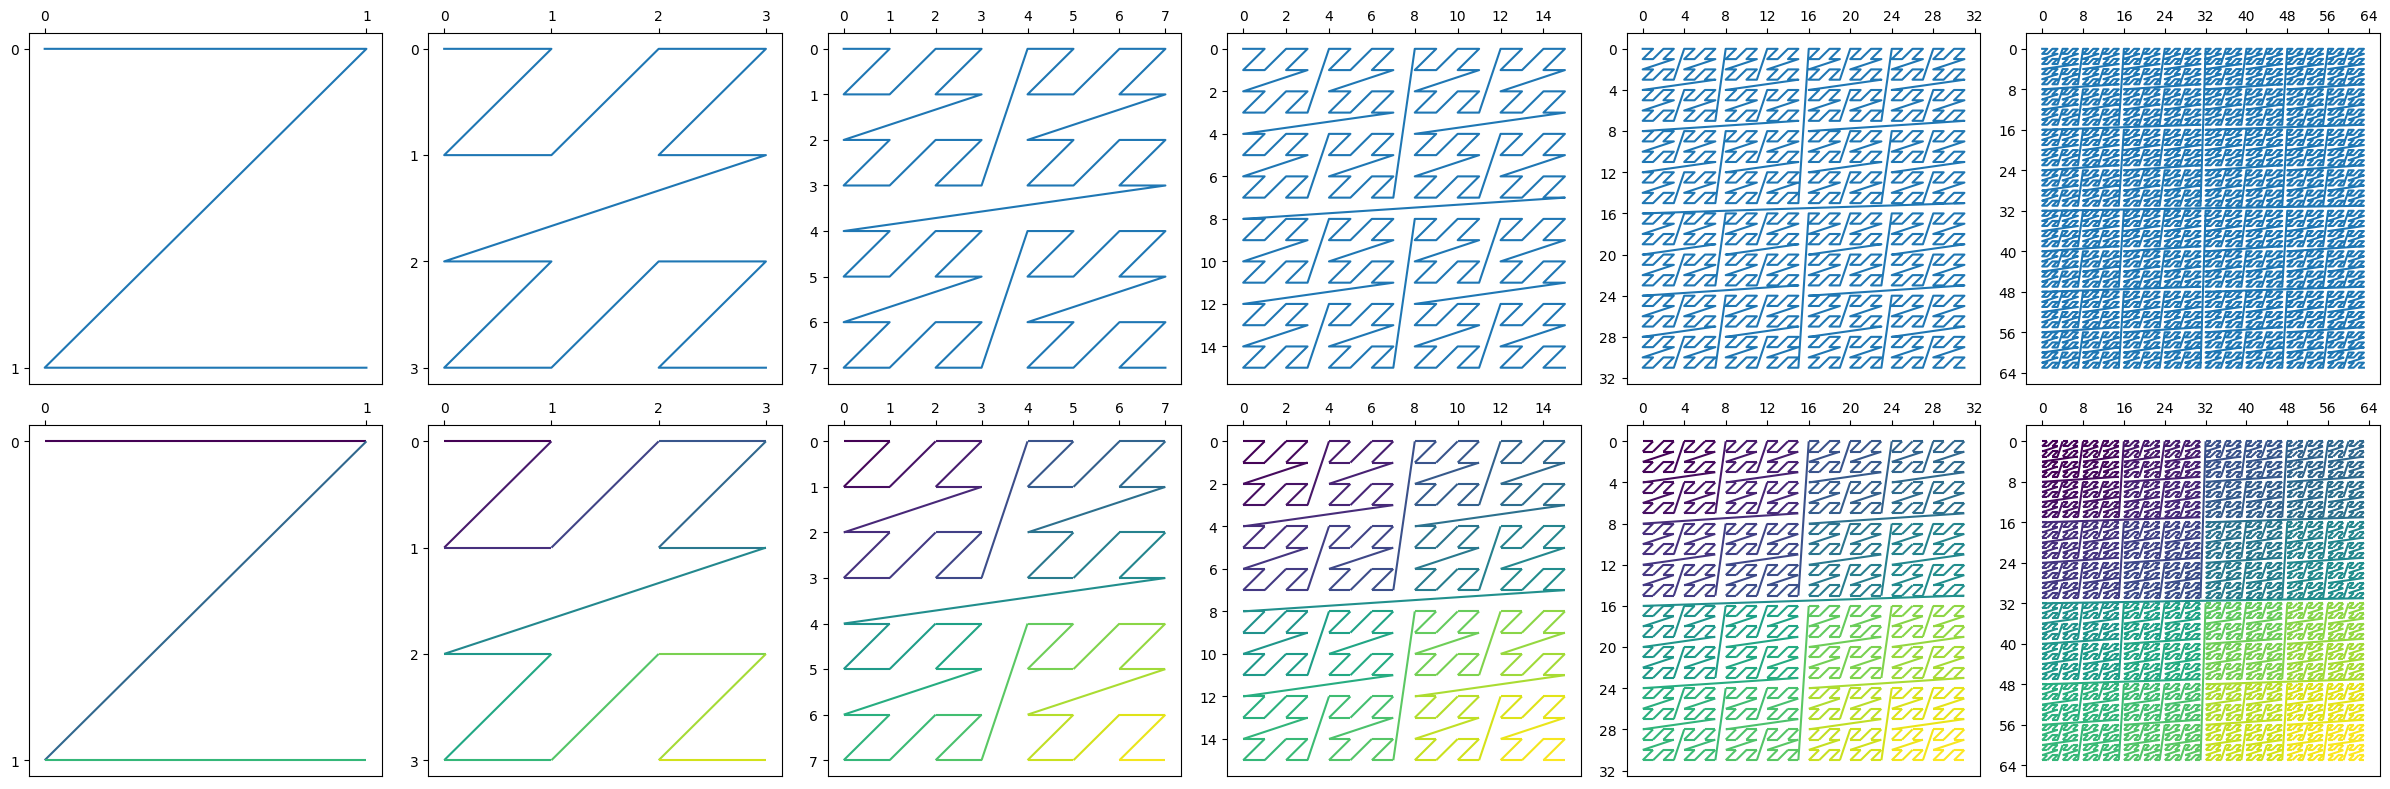

In [3]:
def z_order_curve(size):
    ''' Interleave the binary representation of x and y '''
    res = []
    for ii in range(size):
        for jj in range(size):
            i, j = ii, jj
            index, shift = 0, 0
            while i or j:
                pair = (i & 1) | ((j & 1) << 1)
                index |= pair << shift
                shift += 2
                i >>= 1
                j >>= 1
            res.append((index, ii, jj))
    res.sort()
    return [(i, j) for _, i, j in res]

plot_orders(z_order_curve, [2, 4, 8, 16, 32, 64])

## peano curve

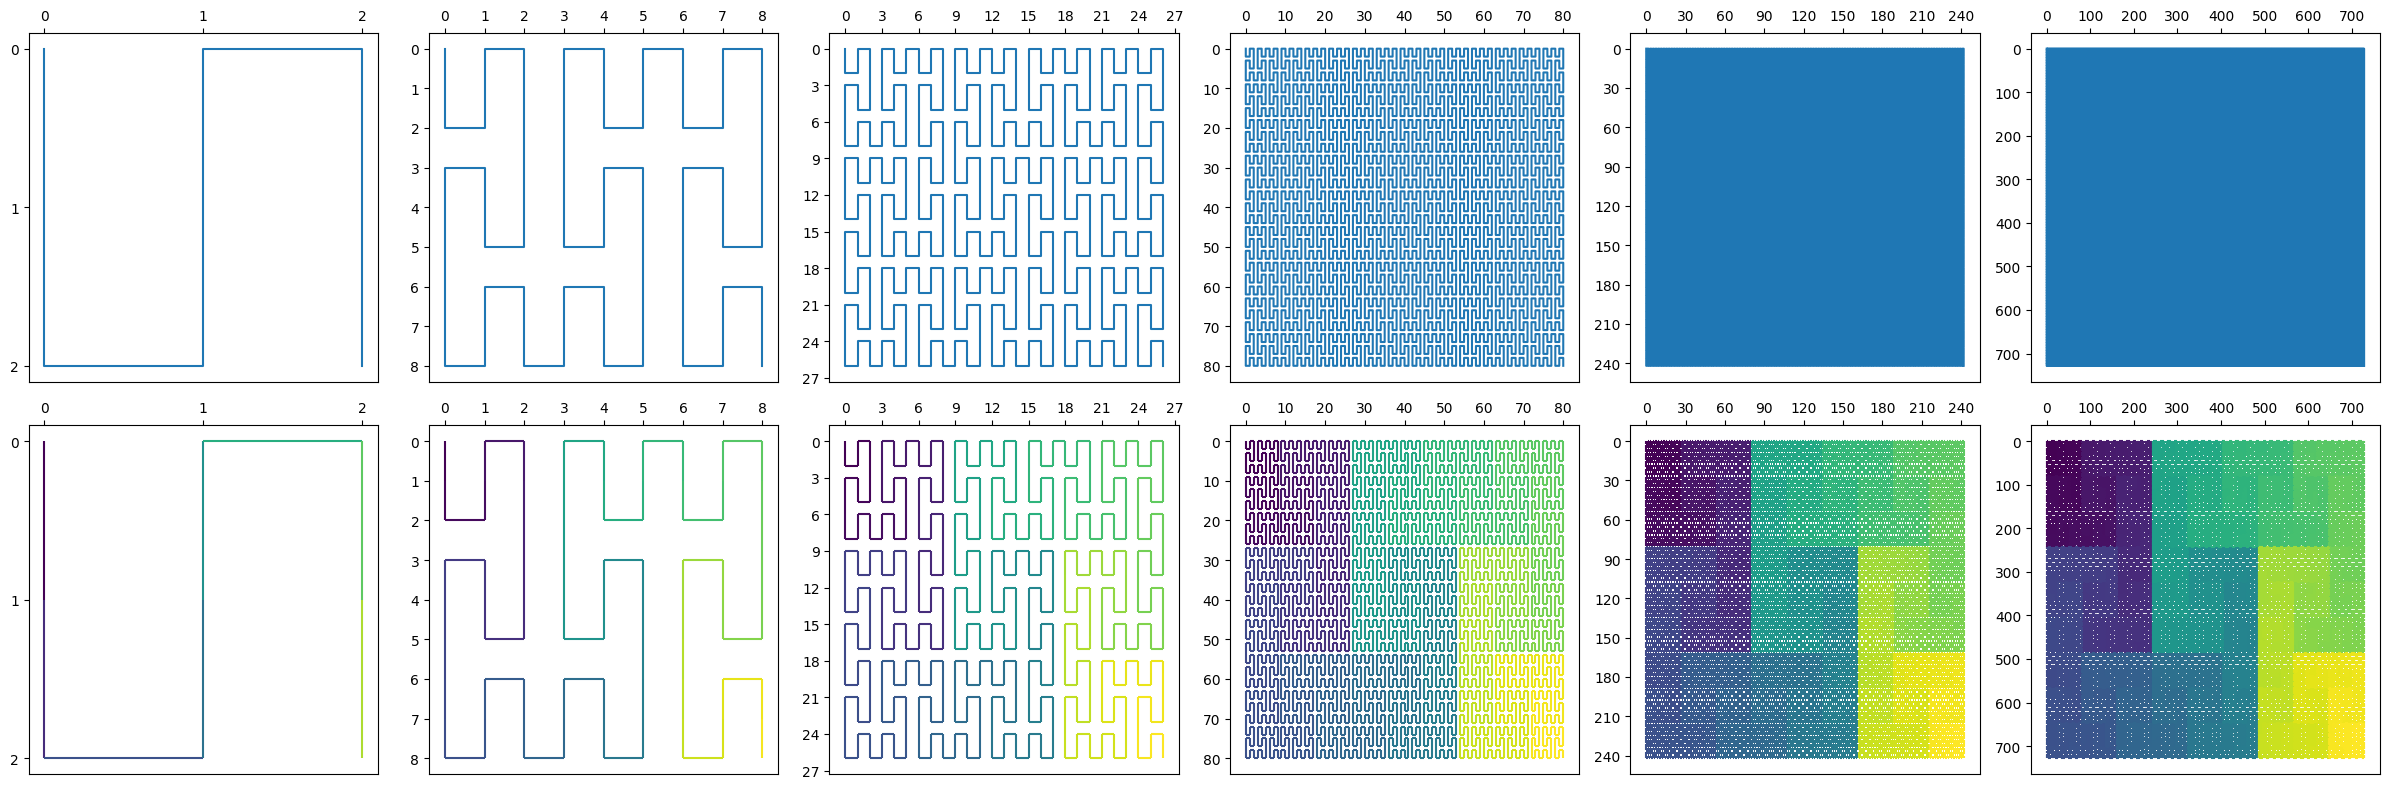

In [4]:
def peano_curve(order):
    res = []
    def rec(order, x, y, dx, dy):
        if order == 0:
            res.append((y, x))
            return (x, y)
        x, y = rec(order - 1, x, y, dx, dy)
        x += dx
        x, y = rec(order - 1, x, y, dx, -dy)
        x += dx
        x, y = rec(order - 1, x, y, dx, dy)
        y += dy
        x, y = rec(order - 1, x, y, -dx, dy)
        x -= dx
        x, y = rec(order - 1, x, y, -dx, -dy)
        x -= dx
        x, y = rec(order - 1, x, y, -dx, dy)
        y += dy
        x, y = rec(order - 1, x, y, dx, dy)
        x += dx
        x, y = rec(order - 1, x, y, dx, -dy)
        x += dx
        x, y = rec(order - 1, x, y, dx, dy)
        return (x, y)
    rec(order, 0, 0, 1, 1)
    return res

plot_orders(peano_curve)

## hilbert curve

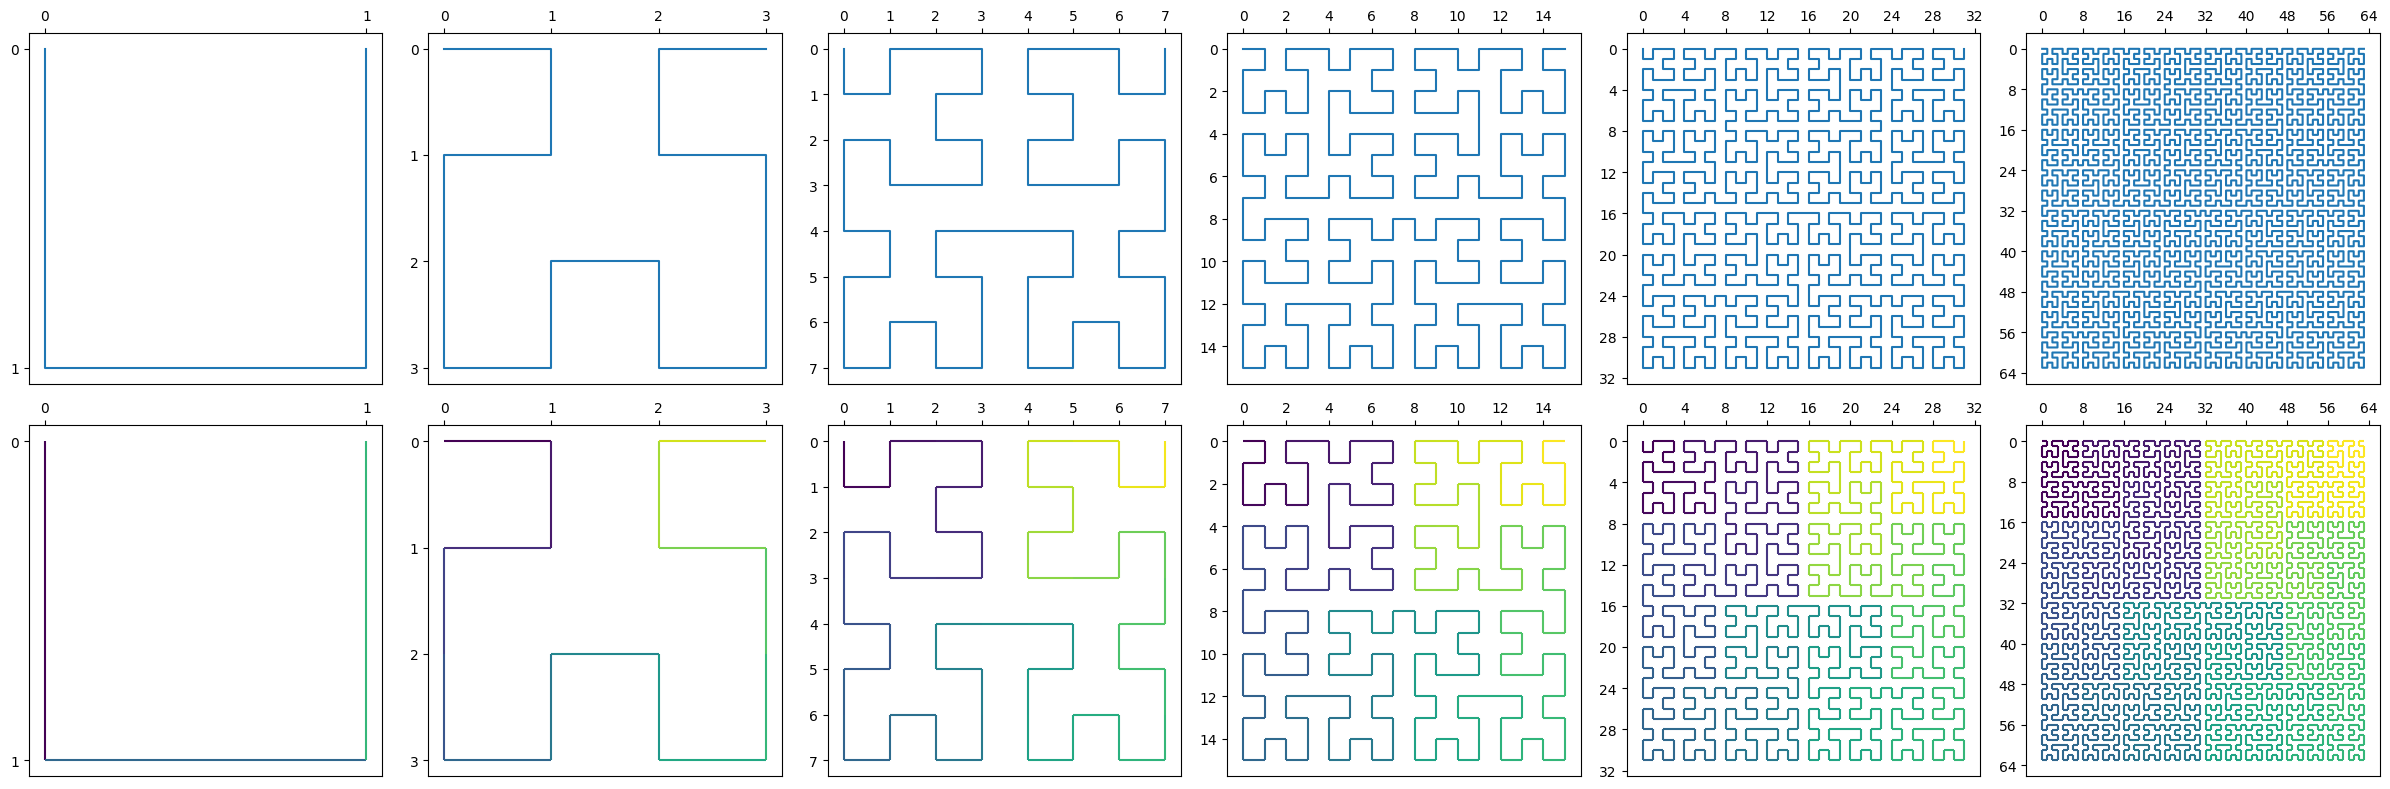

In [5]:
def hilbert_curve(order):
    dirs = [(0, 1), (-1, 0), (0, -1), (1, 0)]
    res = []
    def rec(order, x, y, dir, t):
        if order == 0:
            res.append((x, y))
            return x, y
        dir = dir % 4
        x, y = rec(order - 1, x, y, dir + t, -t)
        dx, dy = dirs[dir]
        x, y = x + dx, y + dy
        x, y = rec(order - 1, x, y, dir, t)
        dx, dy = dirs[(dir + t) % 4]
        x, y = x + dx, y + dy
        x, y = rec(order - 1, x, y, dir, t)
        dx, dy = dirs[(dir + 2) % 4]
        x, y = x + dx, y + dy
        x, y = rec(order - 1, x, y, dir - t, -t)
        return x, y
    rec(order, 0, 0, 0, -1)
    return res

plot_orders(hilbert_curve)

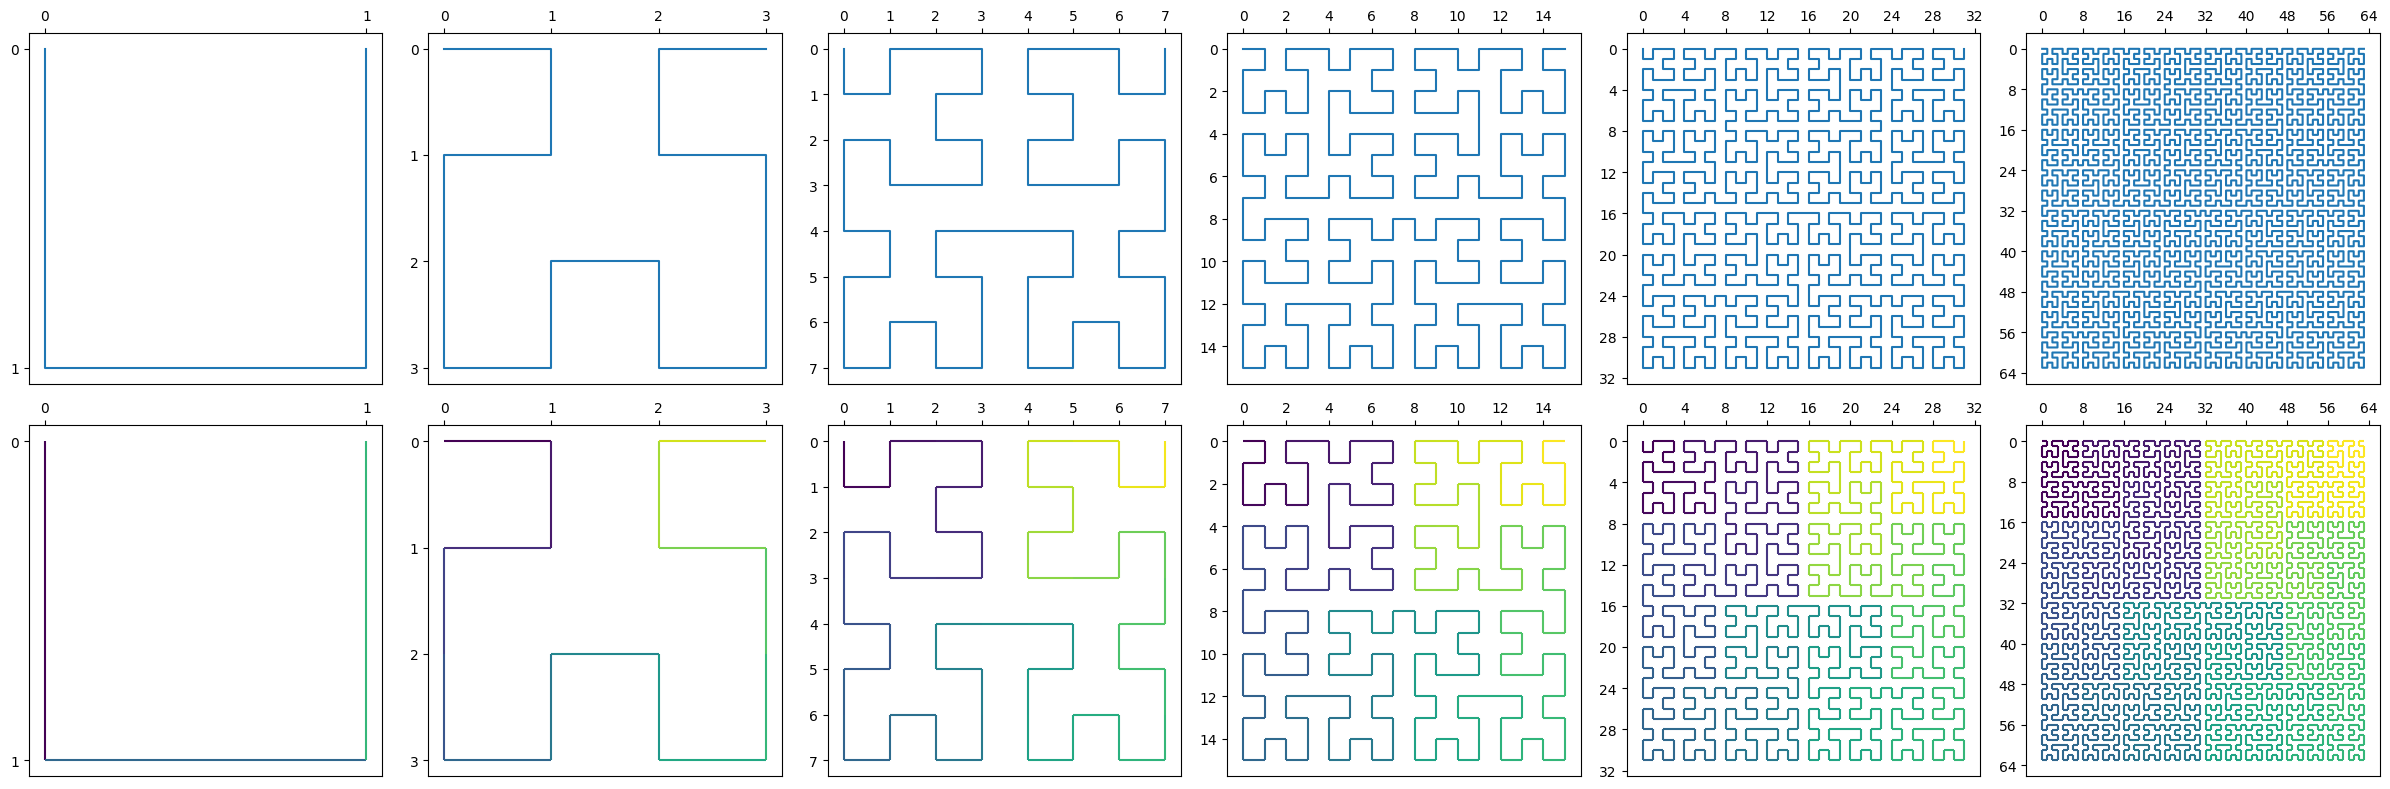

In [6]:
def hilbert_curve2(order):
    def d2xy(size, d):
        t = d
        x = y = 0
        s = 1
        while s < size:
            rx = 1 & (t // 2)
            ry = 1 & (t ^ rx)
            x, y = rot(s, x, y, rx, ry)
            x += s * rx
            y += s * ry
            t //= 4
            s *= 2
        return x, y

    def rot(size, x, y, rx, ry):
        if ry == 0:
            if rx == 1:
                x = size - 1 - x
                y = size - 1 - y
            x, y = y, x
        return x, y

    size = 2 ** order
    points = [d2xy(size, d) for d in range(size**2)]
    return points

plot_orders(hilbert_curve2)